# Chapter 1 Exercises

In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap, local_device_count, pmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim

from numpyro.infer import MCMC, NUTS, HMC, Predictive
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation


seed=1234

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu") # or "gpu", "tpu" depending on system
numpyro.set_host_device_count(local_device_count())

## Question 1
***

We do not know whether the brain really works in a Bayesian way, in an approximate Bayesian fashion, or maybe some evolutionary (more or less) optimized heuristics. Nevertheless, we know that we learn by exposing ourselves to data, examples and exercises - well, you may say that humans never learn, given our record as a species on subjects such as wars or economic systems that prioritize profit and not people's well-being... Anyway, I recommend you do the proposed exercises at the end of each chapter.

*From the following expressions, which one corresponds to the sentence "the probability of being sunny, given that it is the 9th of July of 1816"?*
- p(sunny)
- p(sunny | July)
- p(sunny | 9th of July of 1816)
- p(9th of July of 1816 | sunny)
- p(sunny, 9th of July of 1816) / p(9th of July of 1816)


There are two statements that correspond to the *Probability of being sunny given that it is the 9th of July of 1816*

1. p(sunny | 9th of July of 1816)
2. p(sunny, 9th of July of 1816) / p(9th of July of 1816)

For the second one recall the product rule (Equation 1.1)

$$ p(A,B) = p(A|B)p(B) $$

A rearrangement of this formula yields

$$ p(A|B) = \frac{p(A, B)}{p(B)}$$

Replace A and B with "sunny" and "9th of July of 1816" to get the equivament formulation.

## Question 2
***

*Show that the probability of choosing a human at random and picking the Pope is not the same as the probability of the Pope being human.*

Let's assume there are 6 billion humans in the galaxy and there is only 1 Pope, Pope Francis, at the time of this writing. If a human is randomly picked the chances of that human being the pope are 1 in 6 billion. In mathematical notation

$$ p(Pope | human) = \frac{1}{6,000,000} $$

Additionally I am very confident that the Pope is human, so much so that I make this statement. *Given a pope, I am 100% certain they are human*.   
Written in math
$$ p(human | Pope) = 1 $$

*In the animated series Futurama, the (space) Pope is a reptile. How does this change your previous calculations?*

Ok then:

$$ p(Pope | human) = 0 $$

And 

$$ p(human | Pope) = 0 $$

## Question 3
***

*In the following definition of a probabilistic model, identify the prior and the likelihood:*

\begin{eqnarray}
y_i \text{~} Normal(\mu, \sigma) \newline
\mu \text{~} Normal(0,10) \newline
\sigma \text{~} HalfNormal(25) 
\end{eqnarray}

The priors in the model are

\begin{eqnarray}
\mu \text{~} Normal(0,10) \newline
\sigma \text{~} HalfNormal(25) 
\end{eqnarray}

The likelihood in our model is  
$$ y_i \text{~} Normal(\mu, \sigma) $$

## Question 4
***

*In the previous model, how many parameters will the posterior have? Compare it with the model for the coin-flipping problem.*

In the previous question there are two parameters in the posterior, $\mu$ and $\sigma$. 

In our coin flipping model we had one parameter, $\theta$. It may seem confusing that we had $\alpha$ and $\beta$ as well, but remember, these were not parameters we were trying ot estimate. In other words we don't really care about $\alpha$ and $\beta$ - they were just values for our prior distribution. What we really wanted was $\theta$, to determine the fairness of the coin.

## Question 5
***

*Write Bayes' theorem for the model in question 3.*

$$ p(\mu, \sigma | y) = \frac{p(y| \mu, \sigma)p(\mu)p(\sigma)}{p(y)} $$

## Question 6
***

*Let's suppose that we have two coins. When we toss the first coin, half the time it lands on tails and the other half on heads. The other coin is a loaded coin that always lands on heads. If we take one of the coins at random and get heads, what is the probability that this coin is the unfair one?*

Formalizing some of the statements into mathematical notation:

The probability of picking a coin at random, and getting either the biased or fair coin is the same:

$$p(Biased) = p(Fair) = .5$$

The probability of getting heads with the biased coin is 1,
$$p(Heads | Biased) = 1$$

The probability of getting heads with the fair coin is .5
$$p(Heads | Fair) = .5$$

Lastly, remember that after picking a coin at *random*, we observed heads. Therefore we can use Bayes rule to calculate the probability that we picked the biased coin:

$$ p(Biased | Heads) = \frac{p(Heads | Biased) p(Biased)}{p(Heads)} $$

To solve this by hand we need to rewrite the denominator using the *Rule of Total Probability*:

$$ p(Biased | Heads) = \frac{p(Heads | Biased) p(Biased)}{p(Heads|Fair)*p(Fair) + p(Heads|Biased)*p(Biased)} $$

We can use Python to do the math for us:

In [2]:
(1 * .5)/(.5 * .5 + 1* .5)

0.6666666666666666

## Questions 7 & 8
***

*Modify the code that generated Figure 1.5, in order to add a dotted vertical line showing the observed rate of $\frac{Heads}{Number-of-tosses} $. Compare the location of this line to the mode of the posteriors in each subplot.*

*Try re-running this code using other priors (`beta_params`) and other data (`n_trials` and `data`).*

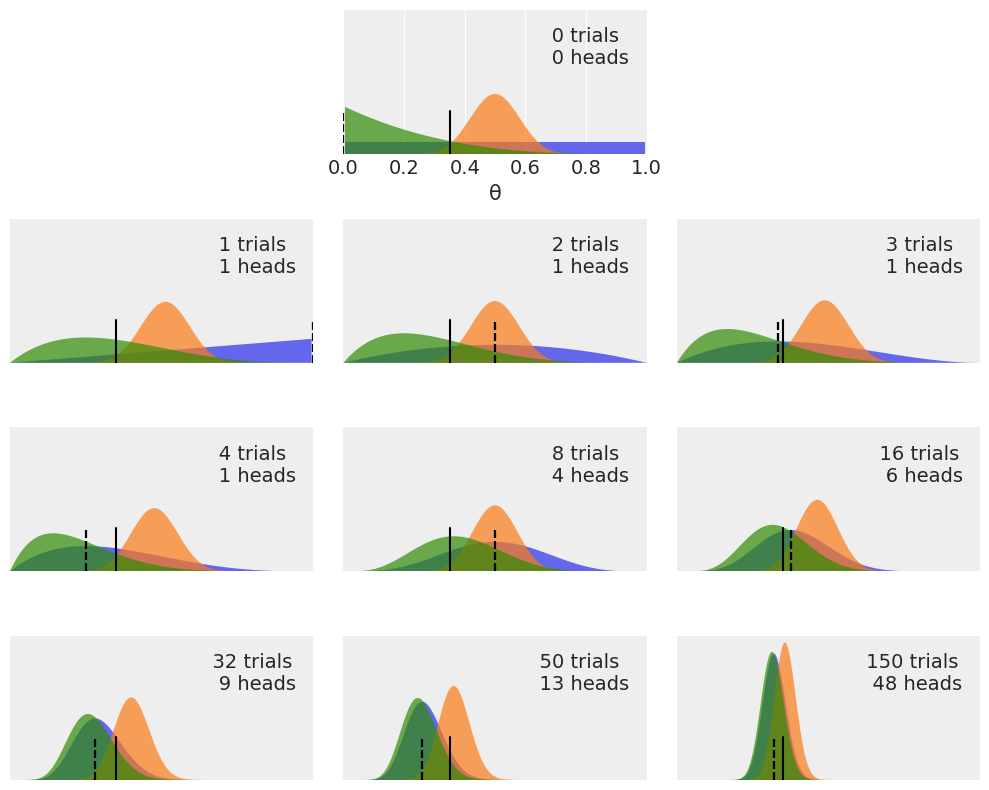

In [4]:
plt.figure(figsize=(10, 8))

n_trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]
theta_real = 0.35

beta_params = [(1, 1), (20, 20), (1, 4)]
x = jnp.linspace(0, 1, 200)

for idx, N in enumerate(n_trials):
    if idx == 0:
        plt.subplot(4, 3, 2)
        plt.xlabel('θ')
    else:
        plt.subplot(4, 3, idx+3)
        plt.xticks([])
    
    y = data[idx]
    
    for (a_prior, b_prior) in beta_params:
        p_theta_given_y = jnp.exp(dist.Beta(a_prior + y, b_prior + N - y).log_prob(x))
        plt.fill_between(x, 0, p_theta_given_y, alpha=0.7)
        
        # Add Vertical line for Number of Heads divided by Number of Tosses
        try:
            unit_rate_per_toss = y/N
        except ZeroDivisionError:
            unit_rate_per_toss = 0
        plt.axvline(unit_rate_per_toss, ymax=0.3, color='k', linestyle="--")

    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.plot(0, 0, label=f'{N:4d} trials\n{y:4d} heads', alpha=0)
    plt.xlim(0, 1)
    plt.ylim(0, 12)
    plt.legend()
    plt.yticks([])
    
    
plt.tight_layout();

## Question 9
***

*Go to the chapter's notebook and explore different parameters for the Gaussian, binomial and beta plots (figures 1.1, 1.3 and 1.4 from the chapter). Alternatively, you may want to plot a single distribution instead of a grid of distributions.*

## Question 10
***

*Read about [Cromwell's rule](https://en.wikipedia.org/wiki/Cromwell%27s_rule) on Wikipedia.*

## Question 11
***

*Read about [probabilities and the Dutch book](https://en.wikipedia.org/wiki/Dutch_book) on Wikipedia.*